# This notebook explores the use of a transformer model for predicting beaching locations with the Asia watershed

In [1]:
# set working directory
import os
os.chdir('/dat1/openonic/Drifters') # directory

In [2]:
# dependencies
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import math

import torch
import torch.nn as nn
import torch.nn.utils.rnn as rnn_utils
from torch.nn.utils.rnn import pad_sequence, pack_padded_sequence
from torch import Tensor
from torch.nn import Transformer
from torch.utils.data import DataLoader

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

from timeit import default_timer as timer

import tqdm

from mpl_toolkits.mplot3d import Axes3D

import seaborn as sns
sns.set(style = 'whitegrid', font_scale = 2.5)

In [3]:
# set random seed
seed = 42
torch.random.manual_seed(seed)
np.random.seed(seed)

In [4]:
# load data
Asia = pd.read_csv('selected_clusters/cluster_16_data.csv').drop(columns = 'HDBSCAN')

## Let's look at our dataset: Asia Beaching Watershed

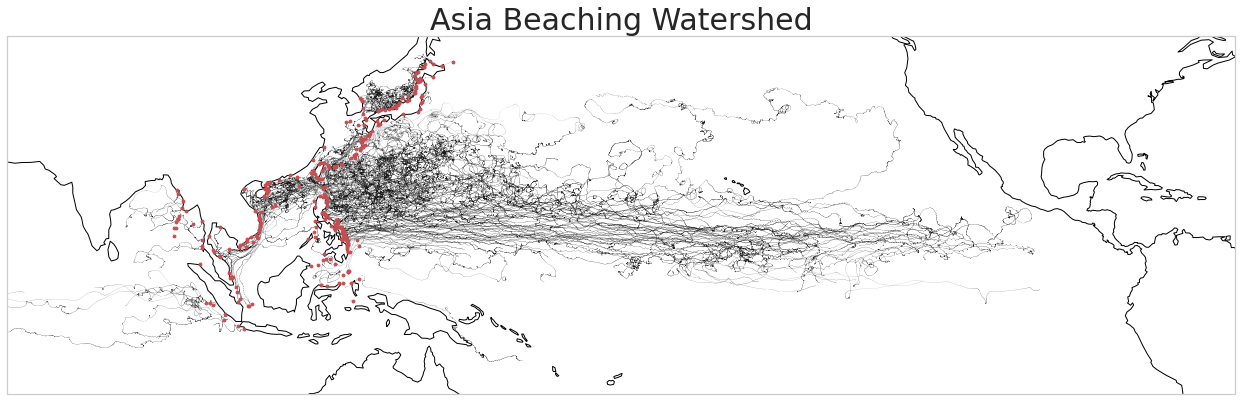

In [5]:
# take a look at the drifter trajectories and beaching locations
beach = Asia
beaching_points = Asia.drop_duplicates(subset='id', keep='last')

point_size = 0.00005

fig = plt.figure(figsize=(22, 12))
ax = plt.axes(projection=ccrs.PlateCarree(central_longitude=-180))
ax.set_extent([120, -120, -20, 50], crs=ccrs.PlateCarree(central_longitude=-180))
ax.coastlines()

# Scatter plot with colors based on the custom colormap
scatter2 = ax.scatter(
    beach['lon'],
    beach['lat'],
    marker='o',
    c='k',
    cmap='viridis',
    transform=ccrs.PlateCarree(),  # Specify the coordinate reference system
    s=point_size,
    alpha=0.7
)

ax.scatter(beaching_points['lon'], beaching_points['lat'], color='r', transform=ccrs.PlateCarree(), s = 8)  # Specify the coordinate reference system

plt.title('Asia Beaching Watershed', fontsize = 30)
plt.show()

## Let's prepare and clean our data by: 
## 1. Applying a coordinate transform and normalizing 
## 2. Let's split into source and target sequences (src, tgt)

Converting into tensors and padding 
## 3. Splitting into train, test, validation, and target
## 4. Apply a masking function
## 5. Collation?
##
### Let's start with 1.

We first need to solve the spatial problem inherent to latitude/longitude coordinate data. The distance between one degree of longitude and another is greatest at the equator and smallest at the poles: in fact, as one approaches the poles, the distance in a degree of longitude gets exponentially small. Another problem is that -180 degrees longitude is equal to 180 degrees longitude, this is far from helpful to a neural network. How do we normalize this kind of data? Let's apply a coordinate transform, converting latitude and longitude to the x, y, z coordinates of a sphere (we make the assumption the Earth is a perfect sphere, it isn't, but this shouldn't impact our results in any significant way). The next block of code defines a function to achieve this transformation and shows a 2-d lat/lon map before and 3-d x,y,z sphere after.

In [6]:
# we define a function to transform lat/lon to x,y,z and normalize while we're at it
def coord_transform_normalize(lat_list, lon_list, scaler):
    
    # convert to radians for use of np.cos, np.sin
    lats_r, lons_r = np.radians(lat_list), np.radians(lon_list)
    
    # transform lat/lon to x, y, z
    x = np.cos(lons_r) * np.cos(lats_r)
    y = np.sin(lons_r) * np.cos(lats_r) 
    z = np.sin(lats_r) 
    
    # stack x,y,z coords
    xyz_coords = np.column_stack((x, y, z))
    
    # fit scaler to the coords and apply normalization
    norm_xyz_coords = scaler.fit_transform(xyz_coords)
    
    # split back into x,y,z
    norm_x, norm_y, norm_z = np.hsplit(norm_xyz_coords, 3)

    return norm_x, norm_y, norm_z

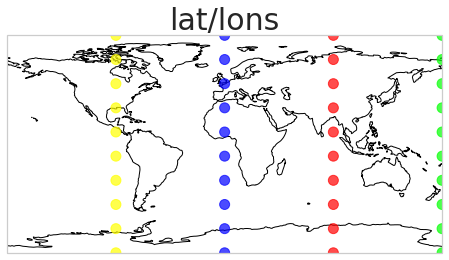

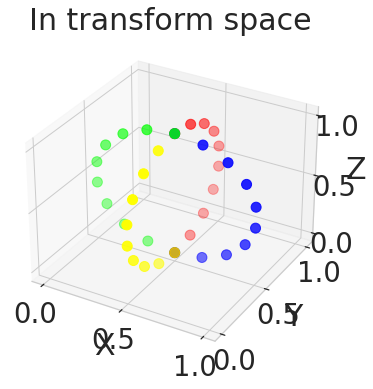

In [7]:
# now we apply this transform to some toy lat/lons:
toy_latitudes_1 = np.array(np.linspace(-90,90,10))
toy_longitudes_1 = np.array(np.ones(10) * 90)
                              
toy_latitudes_2 = np.array(np.linspace(-90,90,10))
toy_longitudes_2 = np.array(np.ones(10) * 180)

toy_latitudes_3 = np.array(np.linspace(-90,90,10))
toy_longitudes_3 = np.array(np.zeros(10))

toy_latitudes_4 = np.array(np.linspace(-90,90,10))
toy_longitudes_4 = np.array(np.ones(10) * -90)


toy_latitudes = np.concatenate((toy_latitudes_1, toy_latitudes_2, toy_latitudes_3, toy_latitudes_4))
toy_longitudes = np.concatenate((toy_longitudes_1, toy_longitudes_2, toy_longitudes_3, toy_longitudes_4))

# initialize MinMaxScaler
toy_scaler = MinMaxScaler()

toy_x, toy_y, toy_z = coord_transform_normalize(toy_latitudes, toy_longitudes, toy_scaler)

# let's plot both x,y,z and lat, lon to visualize how the transform works:
fig = plt.figure(figsize=(10, 4))
ax = plt.axes(projection=ccrs.PlateCarree(central_longitude=0))
ax.set_extent([-180, 180, -90, 90], crs=ccrs.PlateCarree(central_longitude=0))
ax.coastlines()
point_size = 100
color1 = np.array([[255, 0, 0]] * 10) / 255.0  # Red
color2 = np.array([[0, 255, 0]] * 10) / 255.0  # Green
color3 = np.array([[0, 0, 255]] * 10) / 255.0  # Blue
color4 = np.array([[255, 255, 0]] * 10) / 255.0  # Yellow
colors = np.concatenate((color1, color2, color3, color4))
toy_scatter_red =ax.scatter(
    toy_longitudes,
    toy_latitudes,
    marker='o',
    c=colors,
    transform=ccrs.PlateCarree(),  # Specify the coordinate reference system
    s=point_size,
    alpha=0.7)

plt.title('lat/lons')
plt.show()

# plot 3D transform
fig = plt.figure(figsize=(12, 6))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(toy_x, toy_y, toy_z, s = 100, c= colors)
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
plt.title('In transform space')

plt.show()

In [39]:
# let's apply the coordinate transform and normalization
# initialize MinMaxScaler for coords
coord_scaler = MinMaxScaler()
# apply coordinate transform and normalization to coords
Asia_x, Asia_y, Asia_z = coord_transform_normalize(Asia['lat'], Asia['lon'], coord_scaler)

# initialize MinMaxScaler for time_to_beach
#time_to_beach_scaler = MinMaxScaler()
#Asia_time_to_beach_norm = time_to_beach_scaler.fit_transform(np.array(Asia['time_to_beach']).reshape(-1,1))

Asia_norm = Asia.drop(columns = ['lat', 'lon','time_to_beach']).assign(x = Asia_x, y = Asia_y, z = Asia_z)

### 2. Let's continue by defining the source and target sequences for each trajectory

In [40]:
# group Asia_xyz_norm watershed by unique id and order each row as 'unique id' 
# then subsequent feature columns consisting of lists
Asia_by_traj = Asia_norm.groupby('id').agg(lambda x: x.tolist()).reset_index() 

# remove trajectories with less than 1000 trajectories
Asia_by_traj['Traj_Length'] = Asia_by_traj['time'].apply(len)
Asia_by_traj = Asia_by_traj[Asia_by_traj['Traj_Length'] >= 1000].drop(columns='Traj_Length')

# FOR REDUCING MODEL SIZE-------------------------------------------------------------------
Asia_by_traj = Asia_by_traj[0:12]

In [41]:
# split into src and tgt
# save ids
id_column = Asia_by_traj['id']
# create src dataframe as the first 80% of sequential data in each row
Asia_src = Asia_by_traj.drop(columns=['id']).apply(lambda row: row.apply(lambda lst: lst[:int(len(lst) * 0.8)]), axis=1)

# create tgt dataframe as the remaining 20% of sequential data in each row
Asia_tgt = Asia_by_traj.drop(columns=['id']).apply(lambda row: row.apply(lambda lst: lst[int(len(lst) * 0.8):]), axis=1)

# add ids back
Asia_src = pd.concat([id_column, Asia_src], axis=1)
Asia_tgt = pd.concat([id_column, Asia_tgt], axis=1)

In [11]:
# reduce the number of data by taking windows of some length and taking the average
def window_avg(data, window_size):
    subsets = [data[i:i+window_size] for 
               i in range(0, len(data), window_size)]
    averaged_data = [np.mean(subsets[i]) for i, _ in enumerate (subsets)]
    return averaged_data

# get data from dataframe and apply reduction
window_size = 50 # set window_size

# src
Asia_src['x'] = [window_avg(x_list, window_size) for x_list in Asia_src['x']]
Asia_src['y'] = [window_avg(y_list, window_size) for y_list in Asia_src['y']]
Asia_src['z'] = [window_avg(z_list, window_size) for z_list in Asia_src['z']]

# tgt
Asia_tgt['x'] = [window_avg(x_list, window_size) for x_list in Asia_tgt['x']]
Asia_tgt['y'] = [window_avg(y_list, window_size) for y_list in Asia_tgt['y']]
Asia_tgt['z'] = [window_avg(z_list, window_size) for z_list in Asia_tgt['z']]

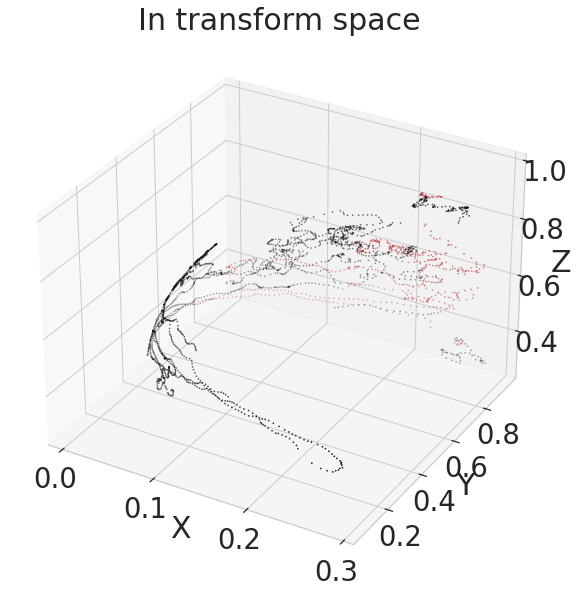

In [12]:
# let's take a look at the output of coordinate transformation, normalization, and splitting into src and tgt:
# x
Asia_src_x = [item for sublist in Asia_src['x'] for item in sublist]
Asia_tgt_x = [item for sublist in Asia_tgt['x'] for item in sublist]

# y
Asia_src_y = [item for sublist in Asia_src['y'] for item in sublist]
Asia_tgt_y = [item for sublist in Asia_tgt['y'] for item in sublist]

# z
Asia_src_z = [item for sublist in Asia_src['z'] for item in sublist]
Asia_tgt_z = [item for sublist in Asia_tgt['z'] for item in sublist]

# plot 3D transform
fig = plt.figure(figsize=(16,10))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(Asia_src_x, Asia_src_y, 
           Asia_src_z, s = 0.5, color ='k')
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

# plot beaching points in red
ax.scatter(Asia_tgt_x, Asia_tgt_y, 
           Asia_tgt_z, s = 0.5, color ='r')
plt.title('In transform space')

plt.show()

In [60]:
# indices values for padding, start of trajectory, and end of trajectory
PAD_IDX, BOS_IDX, EOS_IDX = -1, -2, -3

### 3. Let's split into train, test, validation, and target

In [86]:
# combine x, y, z together into a list of tuples
# src
all_src = [(x, y, z) for x, y, z in zip(Asia_src['x'], Asia_src['y'], Asia_src['z'])]

# tgt
all_tgt = [(x, y, z) for x, y, z in zip(Asia_tgt['x'], Asia_tgt['y'], Asia_tgt['z'])]

# split data and input lengths into training and remaining (for validation and testing)
train_src, remaining_src, train_tgt, remaining_tgt = train_test_split(
    all_src, all_tgt, train_size = 4, random_state = 42) # 175

# split the remaining data and input lengths into validation and test sets
val_src, test_src, val_tgt, test_tgt = train_test_split(
    remaining_src, remaining_tgt, test_size = 4, random_state = 42) # 75

#training_data_src = np.array([np.expand_dims(src, axis=0) for src in train_src])
#training_data_tgt = np.array([np.expand_dims(tgt, axis=0) for tgt in train_tgt])

training_data =  np.array([(src, tgt) for src, tgt in zip(train_src, train_tgt)]).reshape(4, 2, 1, 3)
validation_data =  np.array([(src, tgt) for src, tgt in zip(val_src, val_tgt)]).reshape(4, 2, 1, 3)
testing_data =  np.array([(src, tgt) for src, tgt in zip(test_src, test_tgt)]).reshape(4, 2, 1, 3)

/usr/local/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:19: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/usr/local/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/usr/local/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:21: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when

In [16]:
#[trajectories, src or tgt, length, x or y or z]

### 4. Let's define the masking function

In [17]:
# helper
def generate_square_subsequent_mask(sz):
    mask = (torch.triu(torch.ones((sz, sz))) == 1).transpose(0, 1)
    mask = mask.float().masked_fill(mask == 0, float('-inf')).masked_fill(mask == 1, float(0.0))
    return mask

# mask function
def create_mask(src, tgt):
    src_seq_len = src.shape[0]
    tgt_seq_len = tgt.shape[0]

    # for XYZ coordinate data, the sequences are 3-dimensional (x, y, z)
    # we need to adjust the sequence lengths
   # src_seq_len = src_seq_len // 3
   # tgt_seq_len = tgt_seq_len // 3

    tgt_mask = generate_square_subsequent_mask(tgt_seq_len)
    src_mask = torch.zeros((src_seq_len, src_seq_len)).type(torch.bool)
    
    # padding masks
    src_padding_mask = (src == PAD_IDX).transpose(0, 1)
    tgt_padding_mask = (tgt == PAD_IDX).transpose(0, 1)
    
    return src_mask, tgt_mask, src_padding_mask, tgt_padding_mask

### 5. Collation

In [159]:
# define collcation function to collate data into batch tensors and pad
def collate_fn(data):
    
    # initialize padded data list
    collated_data = []
   
    for batch in data:
        
        # initialize batch padded data list
        batch_padded = []
        
        # calculate the max length of each sample
        max_len = max(len(sample) for sample in batch)
        
        for sample in batch:

            #  pad sequences to the maximum lengths within each batch
            pad_len = max_len - len(sample)

            # pad sequence with PAD_IDX across x, y, and z coordinates (hence the * 3)
            sample_padded = sample + [[PAD_IDX] * 3] * pad_len

            # convert the padded sequence to a tensor and append to the batch list, save as type float32
            batch_padded.append(torch.tensor(sample_padded, dtype=torch.float32))
        
        # restack tensors and append to collated data
        collated_data.append(torch.stack(batch_padded))
        
    return collated_data

### Define training and evaluation functions

In [20]:
# we define a function to train the model for a single epoch
def train_epoch(model, optimizer, data):
    model.train()
    loss_list = []
    train_iter = data
    train_dataloader = DataLoader(train_iter, batch_size=BATCH_SIZE, collate_fn=collate_fn)
    
    for src, tgt in train_dataloader:
        print("Source shape:", src.shape)
        print("Target shape:", tgt.shape)

    for src, tgt in train_dataloader:
        #src = src.to(device)
        #tgt = tgt.to(device)

        tgt_input = tgt[:-1, :]

        # Since we're training, recall we need to mask our input
        src_mask, tgt_mask, src_padding_mask, tgt_padding_mask = create_mask(src, tgt_input)
        print(np.shape(src))
        print(np.shape(src_mask))
        print(np.shape(tgt_input))
        print(np.shape(tgt_mask))
        print(np.shape(src_padding_mask))
        print(np.shape(tgt_padding_mask))
        print(np.shape(src_padding_mask))
        # What do you think the model does with the masks when it's in evaluation mode?
        logits = model(src, tgt_input, src_mask, tgt_mask,src_padding_mask, tgt_padding_mask, src_padding_mask)

        optimizer.zero_grad()

        tgt_out = tgt[1:, :]
        loss = loss_fn(logits.reshape(-1, logits.shape[-1]), tgt_out.reshape(-1))
        loss.backward()

        optimizer.step()
        loss_list.append(loss.item())

    return loss_list

# Define a function to evaluate the model
def evaluate(model):
    model.eval()
    loss_list = []

    val_iter = val_pairs
    val_dataloader = DataLoader(val_iter, batch_size=BATCH_SIZE, collate_fn=collate_fn)

    for src, tgt in val_dataloader:
        #src = src.to(DEVICE)
        #tgt = tgt.to(DEVICE)

        tgt_input = tgt[:-1, :]

        src_mask, tgt_mask, src_padding_mask, tgt_padding_mask = create_mask(src, tgt_input)

        logits = model(src, tgt_input, src_mask, tgt_mask,src_padding_mask, tgt_padding_mask, src_padding_mask)

        tgt_out = tgt[1:, :]
        loss = loss_fn(logits.reshape(-1, logits.shape[-1]), tgt_out.reshape(-1))
        loss_list.append(loss.item())

    return loss_list

### Define transformer model

In [21]:
# Define the actual transformer model
# Question: What are we "transforming" between? We are transforming between tokenized words and underlying patterns
class Drifter_Transformer(nn.Module):
    def __init__(self,
                 num_encoder_layers,
                 num_decoder_layers,
                 embedding_size,
                 num_heads,
                 src_vocab_size,
                 tgt_vocab_size,
                 dim_feedforward = 512,
                 dropout = 0.1):
        super(Drifter_Transformer, self).__init__()
        self.transformer = Transformer(d_model=embedding_size,
                                       nhead=num_heads,
                                       num_encoder_layers=num_encoder_layers,
                                       num_decoder_layers=num_decoder_layers,
                                       dim_feedforward=dim_feedforward,
                                       dropout=dropout)
        self.generator = nn.Linear(embedding_size, tgt_vocab_size)
 #       self.src_tok_emb = TokenEmbedding(src_vocab_size, embedding_size)
 #       self.tgt_tok_emb = TokenEmbedding(tgt_vocab_size, embedding_size)
 #       self.positional_encoding = PositionalEncoding(
 #           embedding_size, dropout=dropout)

    def forward(self,
                src,
                tgt, #trg???
                src_mask,
                tgt_mask,
                src_padding_mask,
                tgt_padding_mask,
                memory_key_padding_mask):
       # src_emb = self.positional_encoding(self.src_tok_emb(src)) # source sequence --> token embedding --> positional encoding
       # tgt_emb = self.positional_encoding(self.tgt_tok_emb(trg)) # target sequence --> token embedding --> positional encoding
        print(np.shape(EMB_SIZE))
        print(np.shape(src))
        print(np.shape(tgt))
        outs = self.transformer(src, tgt, src_mask, tgt_mask, None, #src_emb, tgt_emb
                                src_padding_mask, tgt_padding_mask, memory_key_padding_mask)
        return self.generator(outs)

    def encode(self, src: Tensor, src_mask: Tensor):
        return self.transformer.encoder(self.positional_encoding(
                            self.src_tok_emb(src)), src_mask)

    def decode(self, tgt: Tensor, memory: Tensor, tgt_mask: Tensor):
        return self.transformer.decoder(self.positional_encoding(
                          self.tgt_tok_emb(tgt)), memory,
                          tgt_mask)

## Define hyperparameters

In [22]:
# Define your hyperparameters
SRC_LENGTH = len(train_src)
TGT_LENGTH = len(train_tgt)
EMB_SIZE = 3
NUM_HEADS = 1 # Why 8, or 10? What do you expect to happen if we increase this parameter?
# increasing num heads can increase the model's capacity to understanding diverse
# representations, allowing the heads to increase the model's learning complexity.
# It may become redundant, though, and lead to slow run times without much benefit.
# It may increase the performance, or not. Trial and error!
FFN_HID_DIM = 600
BATCH_SIZE = 1
NUM_ENCODER_LAYERS = 1
NUM_DECODER_LAYERS = 1
NUM_EPOCHS = 1

# Define your model, loss function, and optimizer
transformer = Drifter_Transformer(NUM_ENCODER_LAYERS, NUM_DECODER_LAYERS, EMB_SIZE,
                                 NUM_HEADS, SRC_LENGTH, TGT_LENGTH, FFN_HID_DIM)

for p in transformer.parameters():
    if p.dim() > 1:
        nn.init.xavier_uniform_(p)

#transformer = transformer.to(device)

loss_fn = torch.nn.CrossEntropyLoss(ignore_index=PAD_IDX)

optimizer = torch.optim.Adam(transformer.parameters(), lr=0.0001, betas=(0.9, 0.98), eps=1e-9)

# initialize train and val loss lists
train_loss_list = []
val_loss_list = []

### Now, we train the model!

In [23]:
# train the model
for epoch in range(1, NUM_EPOCHS+1):
    start_time = timer()
    train_loss = train_epoch(transformer, optimizer, training_data)
    train_loss_list.extend(train_loss)
    end_time = timer()
    val_loss = evaluate(transformer)
    val_loss_list.extend(val_loss)
    print((f"Epoch: {epoch}, Epoch time = {(end_time - start_time):.3f}s"))


TypeError: can't convert np.ndarray of type numpy.object_. The only supported types are: float64, float32, float16, complex64, complex128, int64, int32, int16, int8, uint8, and bool.

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


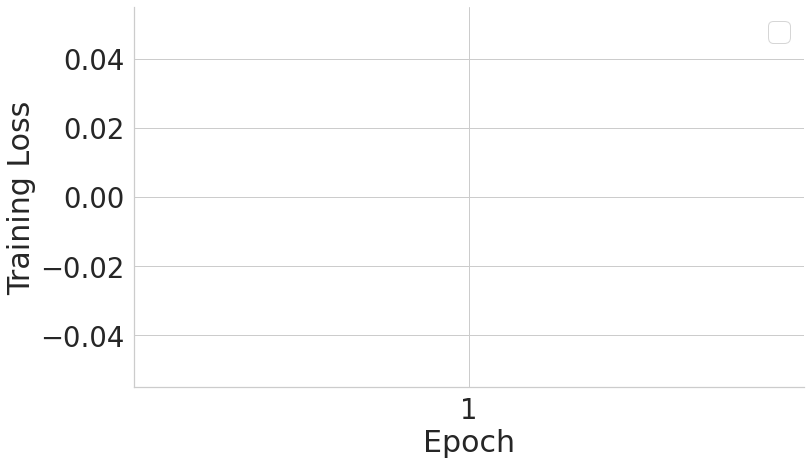

In [140]:
# Let's visualize the training loss
plt.figure(figsize = (12, 7))

plt.scatter(range(len(train_loss_list)), train_loss_list, color = 'blue', linewidth = 3, alpha=0.1)
plt.ylabel("Training Loss")
plt.xlabel("Epoch")
plt.xticks(ticks = [(i+1)*len(train_loss_list)//NUM_EPOCHS for i in range(NUM_EPOCHS)], labels=[f"{i+1}" for i in range(NUM_EPOCHS)])
plt.legend()
sns.despine()

final training loss: 0.3231114149093628
final validation loss: 0.19678455591201782


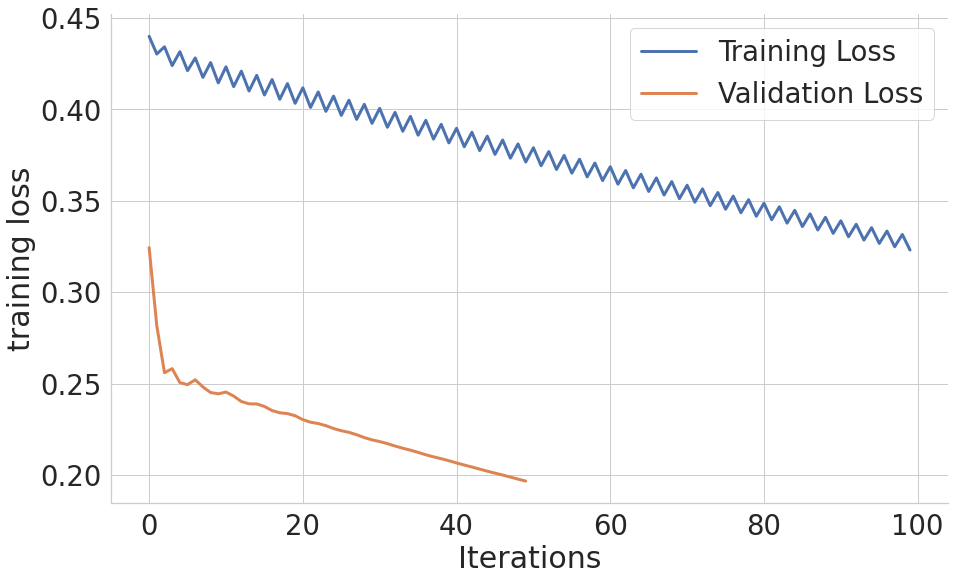

In [27]:
# let's visualize the training and validation loss
print('final training loss: '+ str(train_loss_list[-1]))
print('final validation loss: '+ str(val_loss_list[-1]))

plt.figure(figsize = (15, 9))

plt.plot(train_loss_list, linewidth = 3, label = 'Training Loss')
plt.plot(val_loss_list, linewidth = 3, label = 'Validation Loss')
plt.ylabel("training loss")
plt.xlabel("Iterations")
plt.legend()
sns.despine()

## let's test our model with our test data now!

In [28]:
# activate no_grad() since we aren't performing backprop: testing not training
with torch.no_grad():
    
    # initialize hidden state for the encoder:
    hidden_state = None
    
    # pass training inputs through model to get outputs
    test_outputs, hidden_state = rnn(test_data.float(), test_lengths, hidden_state)
    
    # compute loss
    test_loss = loss_func(test_outputs, test_targets)
print(test_loss.item())

0.3236958086490631


### to convert back to lat/lon coordinates and visualize where the model predicted beaching, we need to perform the inveres of the coord_transform_normalize function on the test output

In [29]:
# we define a function to transform normalized x,y,z output to lat/lon coordinates
def inverse_coord_transform_normalize(model_outputs):
    
    # convert from tensor to list of lists
    model_outputs_list = model_outputs.tolist()
    
    # undo MinMaxScaler normalization
    model_outputs_denorm = [coord_scaler.inverse_transform(np.array(xyz_norm_coords).reshape(-1, 3))
        for xyz_norm_coords in model_outputs_list]
    
    x = [coord[0][0] for coord in model_outputs_denorm]
    y = [coord[0][1] for coord in model_outputs_denorm]
    z = [coord[0][2] for coord in model_outputs_denorm]
    
    lons = np.degrees(np.arctan2(y, x))
    lats = np.degrees(np.arcsin(z))

    return lats, lons

In [30]:
lat_outputs, lon_outputs

(array([-9.24816024, -9.24816024, -9.24816024, -9.24816024, -9.24816024,
        -9.24816024, -9.24816024, -9.24816024, -9.24816024, -9.24816024,
        -9.24816024, -9.24816024, -9.24816024, -9.24816024, -9.24816024,
        -9.24816024, 23.21777654, -9.24816024, -9.24816024, -9.24816024]),
 array([-132.9596486 , -132.9596486 , -132.9596486 , -132.9596486 ,
        -132.9596486 , -132.9596486 , -132.9596486 , -132.9596486 ,
        -132.9596486 , -132.9596486 , -132.9596486 , -132.9596486 ,
        -132.9596486 , -132.9596486 , -132.9596486 , -132.9596486 ,
         118.94345477, -132.9596486 , -132.9596486 , -132.9596486 ]))

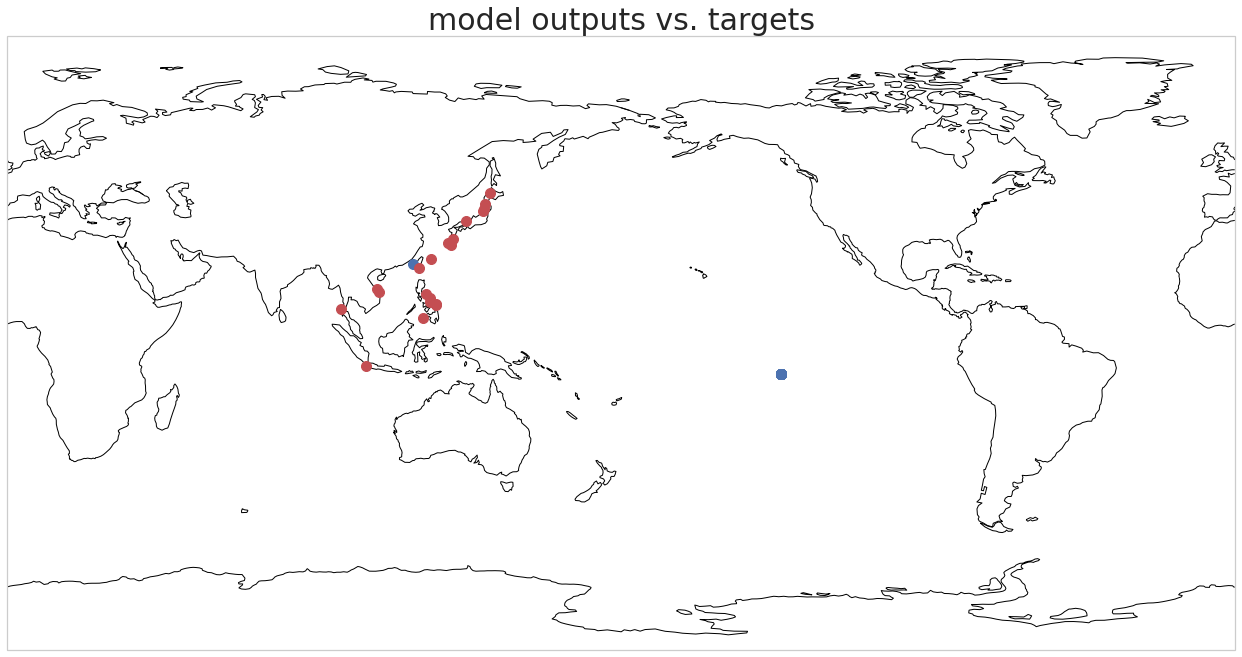

In [31]:
# convert x,y,z normalized outputs to denormalized lat/lon coords
lat_outputs, lon_outputs = inverse_coord_transform_normalize(test_outputs)

# convert x,y,z normalized targets to denormalized lat/lon coords
lat_targets, lon_targets = inverse_coord_transform_normalize(test_targets)

# plot model outputs vs. targets
beach = Asia
beaching_points = Asia.drop_duplicates(subset='id', keep='last')

point_size = 100

fig = plt.figure(figsize=(22, 12))
ax = plt.axes(projection=ccrs.PlateCarree(central_longitude=-180))
ax.set_extent([-180, 180, -90, 90], crs=ccrs.PlateCarree(central_longitude=-180))
ax.coastlines()

# Scatter plot with colors based on the custom colormap
# model outputs
scatter_targets = ax.scatter(
    lon_outputs,
    lat_outputs,
    marker='o',
    c='b',
    transform=ccrs.PlateCarree(),  # Specify the coordinate reference system
    s=point_size,
    alpha=1
)

# targets
scatter_targets = ax.scatter(
    lon_targets,
    lat_targets,
    marker='o',
    c='r',
    transform=ccrs.PlateCarree(),  # Specify the coordinate reference system
    s=point_size,
    alpha=1
)

plt.title('model outputs vs. targets', fontsize = 30)
plt.show()

# Clearly this is very off. Too bad, perhaps an LSTM/GRU or transformer would work better. Coming soon...